In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [3]:
def plot_series(series, series_str, color='red',st_yr=2004, end_yr=2021):
    plt.figure(figsize=(12,6))
    plt.plot(series, color=color)
    plt.ylabel('Search Frequency for {}'.format(series_str), fontsize=16)

    for year in range(st_yr, end_yr):
        plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

In [7]:
ice_cream_heater_df = pd.read_csv('/ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

<ipython-input-7-e3b5909fa836>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ice_cream_heater_df = pd.read_csv('/ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [9]:
ice_cream_heater_df.head()

,heater,ice_cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


In [10]:
heater_series = ice_cream_heater_df.heater
heater_series.head()

Month
2004-01-01    27
2004-02-01    18
2004-03-01    14
2004-04-01    13
2004-05-01    13
Name: heater, dtype: int64

seasonality in heater data, not stationary data


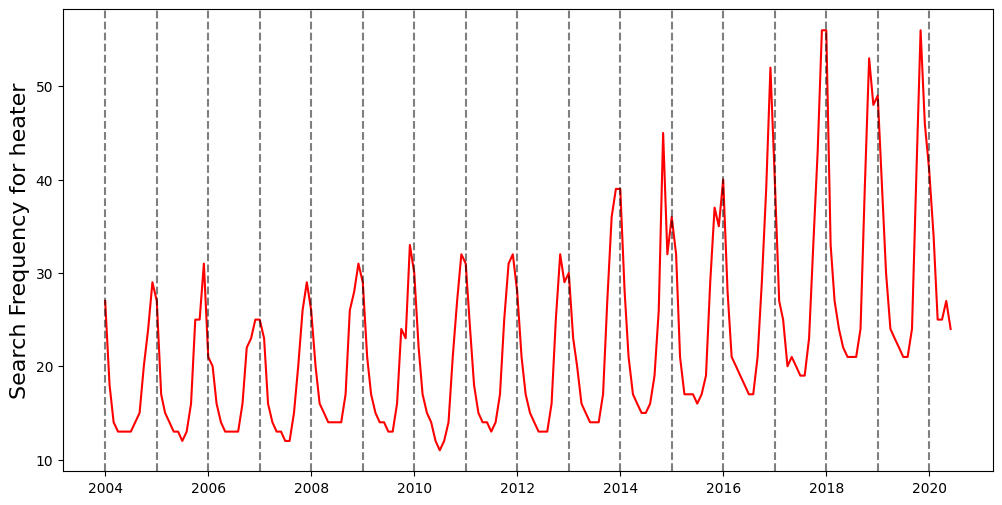

In [13]:
plot_series(heater_series, 'heater')
print('seasonality in heater data, not stationary data')

In [17]:
# normalizing the data
#X-mu/sigma

avg, dev = heater_series.mean(), heater_series.std()
print('avg={}, std ={}'.format(avg,dev))

avg=22.792929292929294, std =9.795500391705835


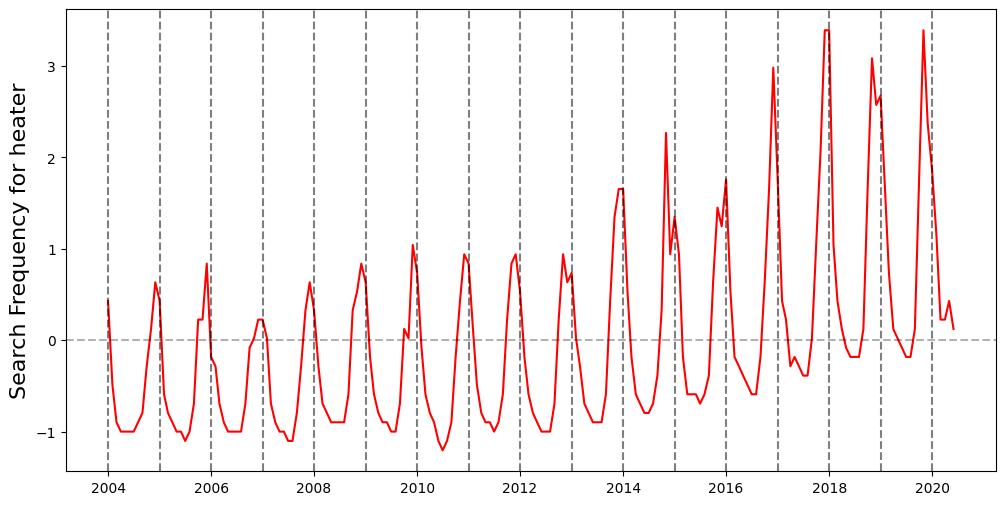

In [19]:
heater_series1 = (heater_series-avg)/dev
plot_series(heater_series1, 'heater')
plt.axhline(0, linestyle='--', color ='k', alpha=0.3)

Now the trend is gone, only beta1 and white noise left; we still have seasonality


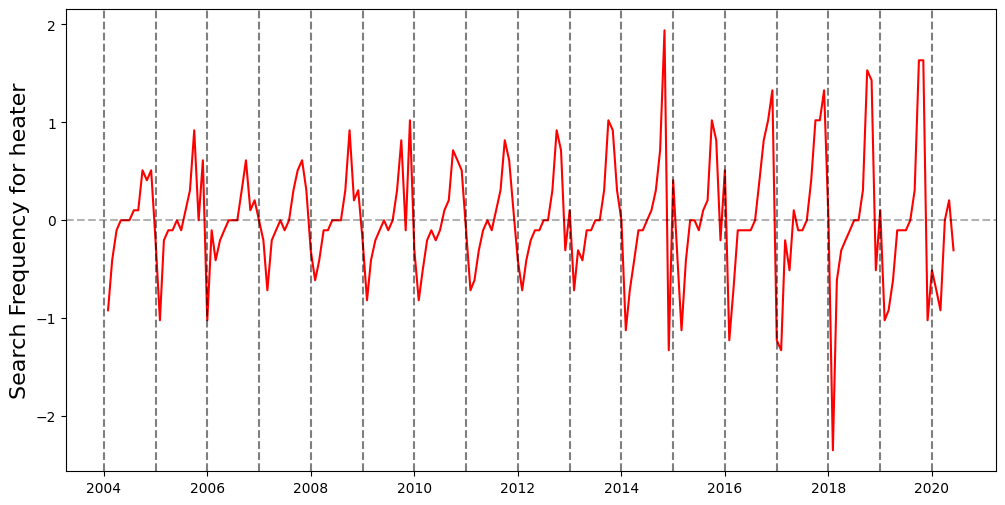

In [23]:
# REMOVING THE TREND IN TIME SERIES - FIRST DIFFERENCE
heater_series2 = heater_series1.diff().dropna()
plot_series(heater_series2, 'heater')
plt.axhline(0, linestyle='--', color ='k', alpha=0.3)
print('Now the trend is gone, only beta1 and white noise left; we still have seasonality')


In [24]:
#Removing Variance in each time frame
annual_variance = heater_series2.groupby(heater_series2.index.year).std()
annual_variance


Month
2004    0.415481
2005    0.474527
2006    0.400148
2007    0.359839
2008    0.396182
2009    0.499810
2010    0.459566
2011    0.443924
2012    0.471104
2013    0.503587
2014    0.855743
2015    0.569441
2016    0.719843
2017    0.830886
2018    0.987221
2019    0.892991
2020    0.426657
Name: heater, dtype: float64

In [27]:
#same dimension data but value replaced for that particular year
heater_annual_v = heater_series2.index.map(lambda d:annual_variance.loc[d.year])
heater_annual_v

Float64Index([0.41548104705328837, 0.41548104705328837, 0.41548104705328837,
              0.41548104705328837, 0.41548104705328837, 0.41548104705328837,
              0.41548104705328837, 0.41548104705328837, 0.41548104705328837,
              0.41548104705328837,
              ...
               0.8929910269067829,  0.8929910269067829,  0.8929910269067829,
               0.8929910269067829, 0.42665652301411994, 0.42665652301411994,
              0.42665652301411994, 0.42665652301411994, 0.42665652301411994,
              0.42665652301411994],
             dtype='float64', name='Month', length=197)

Annual variance is standardized, each interval has roughly the same variance ; we still have seasonality


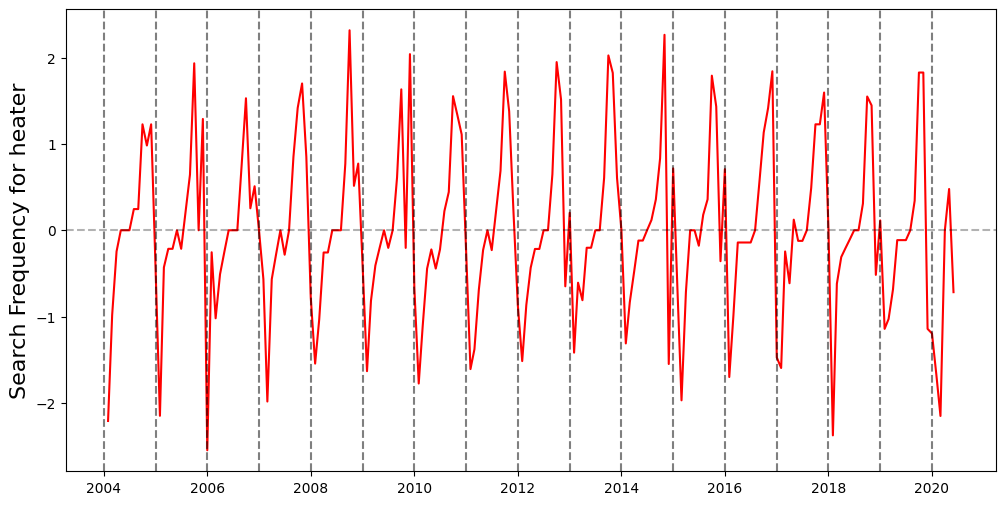

In [29]:
heater_series3= heater_series2/heater_annual_v
plot_series(heater_series3, 'heater')
plt.axhline(0, linestyle='--', color ='k', alpha=0.3)
print('Annual variance is standardized, each interval has roughly the same variance ; we still have seasonality')

In [ ]:
#REMOVE Seasonality
# calculate mean for each month (group by month) and same thing as before
# create heater_monthly_mean as same dimension of heater_series3
# heater_series4 = heater_series3 - heater_monthly_mean

In [38]:
# calculate mean for each month (group by month) and same thing as before
monthly_mean = heater_series3.groupby(heater_series3.index.month).mean()
monthly_mean


Month
1    -0.428360
2    -1.483129
3    -1.063595
4    -0.442926
5    -0.121663
6    -0.128425
7    -0.107093
8     0.075720
9     0.544638
10    1.613170
11    1.183118
12    0.491641
dtype: float64

In [39]:
# create heater_monthly_mean as same dimension of heater_series3
heater_monthly_mean = heater_series3.index.map(lambda d:monthly_mean.loc[d.month])
heater_monthly_mean

Float64Index([ -1.4831292771766649,  -1.0635953355687688,  -0.4429263710136824,
              -0.12166261572164781, -0.12842542811874377, -0.10709260508002622,
               0.07572031336904021,   0.5446384049209761,   1.6131699911888608,
                1.1831180641276995,
              ...
                0.5446384049209761,   1.6131699911888608,   1.1831180641276995,
                0.4916411242912192,  -0.4283597874466263,  -1.4831292771766649,
               -1.0635953355687688,  -0.4429263710136824, -0.12166261572164781,
              -0.12842542811874377],
             dtype='float64', name='Month', length=197)

Annual variance is standardized, each interval has roughly the same variance ; we still have seasonality


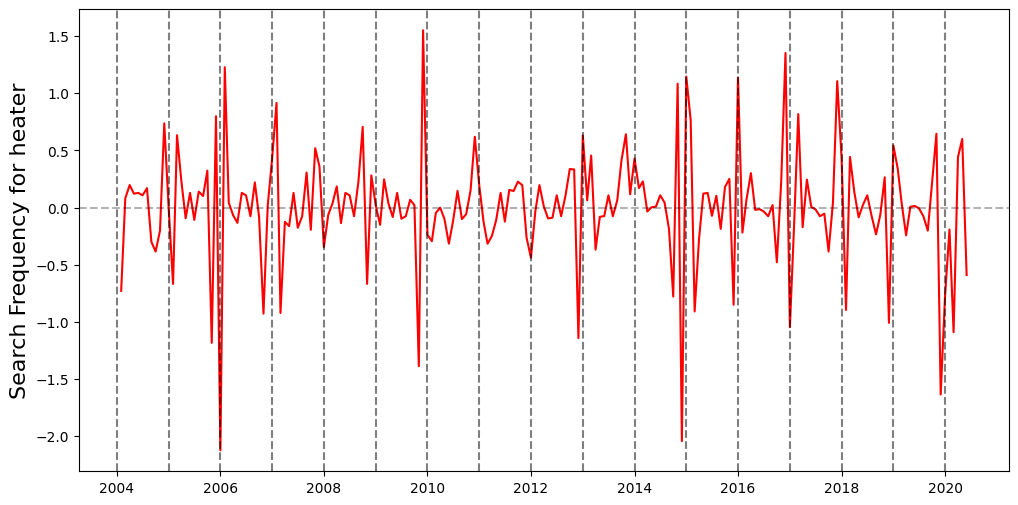

In [40]:
heater_series4 = heater_series3 - heater_monthly_mean
plot_series(heater_series4, 'heater')
plt.axhline(0, linestyle='--', color ='k', alpha=0.3)
print('Annual variance is standardized, each interval has roughly the same variance ; we still have seasonality')